# RNN Lab - Sentiment Classification

In [12]:
# importing relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download(["stopwords", "punkt", "wordnet"])
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU,Dense,Embedding,Dropout, Conv1D,MaxPooling1D,GlobalAveragePooling1D, SimpleRNN 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import kerastuner as kt

import nlpaug.augmenter.word as naw
import torch


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sam_glass/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sam_glass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Loading data

In [13]:
data = pd.read_csv("../Lab_RNN/Data/emotions.csv") # creating data frame from the csv file

data.head()

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness


In [14]:
data.value_counts # using value count to count how many rows in data frame

<bound method DataFrame.value_counts of                                                     text    label
0      i feel so pissed off over an old friend and so...    anger
1      ive found it has made a huge difference especi...    anger
2      i also feel it is unfortunate that nearly all ...  sadness
3                       i feel petty a href http clairee    anger
4      i used to believe that a feeling like fear was...  sadness
...                                                  ...      ...
19995  i was i might be buying stuff from there but i...      joy
19996  i like sonam deepika and genelia who i feel ar...      joy
19997  i feel pathetic that i can hardly go a whole d...  sadness
19998  id have spent more time with her on reading i ...  sadness
19999  i do however feel like one of those pathetic g...  sadness

[20000 rows x 2 columns]>

In [15]:
# Checking for any null values
data.isnull().sum()

text     0
label    0
dtype: int64

In [16]:
duplicates =data[data.duplicated]
print(f"Duplicates {duplicates}")

Duplicates                                                    text label
6154  i feel more adventurous willing to take risks ...   joy


In [17]:
# remove duplicates
data = data.drop_duplicates()

The data set contains 20,000 rows of text lines then classed with an emotion.

<Axes: xlabel='label'>

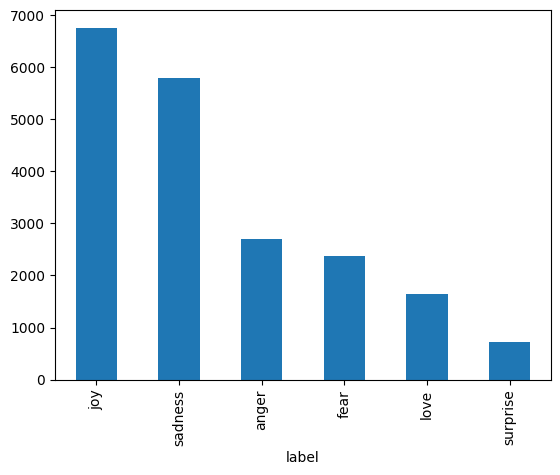

In [18]:
data.label.value_counts().plot.bar() 

Here we can see that the data set is not very equal across all catagories. This may make the training more biased to certain emotions like joy and sadness. We also see that there is six different catagories for the emotions.

In [19]:
joy = data[data["label"]== "joy"]
sadness = data[data["label"]== "sadness"]
anger = data[data["label"]== "anger"]
fear = data[data["label"] == "fear"]
love = data[data["label"] == "love"]
surprise = data[data["label"] == "surprise"]

love = love.sample(n=len(surprise), random_state=42)
fear = fear.sample(n=len(surprise), random_state=42)
anger = anger.sample(n=len(surprise), random_state=42)
sadness = sadness.sample(n=len(surprise), random_state=42)
joy = joy.sample(n=len(surprise), random_state=42)

data = pd.concat([joy,sadness,anger,fear,love,surprise], axis=0)

In [20]:
data.head()

,text,label
17713,i feel so glad that im able to have the time t...,joy
14436,i could look up the coordinates of the cave bu...,joy
8631,i need you i need someone i need to be protect...,joy
6740,i can t imagine a real life scenario where i w...,joy
1381,im feeling very optimistic about it and find m...,joy


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4314 entries, 17713 to 19949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4314 non-null   object
 1   label   4314 non-null   object
dtypes: object(2)
memory usage: 101.1+ KB


<Axes: xlabel='label'>

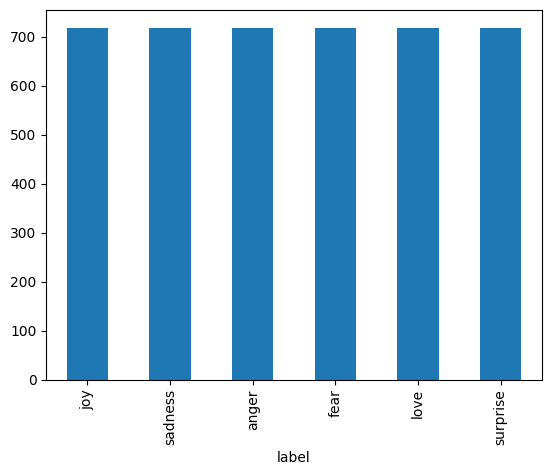

In [22]:
data.label.value_counts().plot.bar() 

In [23]:
def augment_with_emotion(row, aug):
    original_text = row['text']
    original_emotion = row['label']
    
    augmented_text = aug.augment(original_text)
    
    # Create a new row with augmented text and the original emotion label
    augmented_row = {'text_column': augmented_text, 'emotion_column': original_emotion}
    
    return pd.Series(augmented_row)

# Augmenter configuration
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")

# Apply the augmentation function to each row in the DataFrame
augmented_df = data.apply(lambda row: augment_with_emotion(row, aug), axis=1)

# Concatenate the original and augmented DataFrames
data = pd.concat([data, augmented_df], ignore_index=True)

# Display the combined DataFrame
data

,text,label,text_column,emotion_column
0,i feel so glad that im able to have the time t...,joy,NaN,NaN
1,i could look up the coordinates of the cave bu...,joy,NaN,NaN
2,i need you i need someone i need to be protect...,joy,NaN,NaN
3,i can t imagine a real life scenario where i w...,joy,NaN,NaN
4,im feeling very optimistic about it and find m...,joy,NaN,NaN
...,...,...,...,...
8623,NaN,NaN,[i go around people and try i act normal again...,surprise
8624,NaN,NaN,[once i feel no herpes coming home i would be ...,surprise
8625,NaN,NaN,[yet i like to sometimes do extreme things tha...,surprise
8626,NaN,NaN,[i feel almost like approaching a monster beca...,surprise


#### Preprocessing

In [24]:
# Even though the data does not seem to have and Upper case or punctuation it may be good to do as there is many lines to check through manually
data.loc[:, "text"] = data["text"].str.lower().str.replace('[^\w\s]','') # convert text to lowercase and remove punctuation
data.loc[:, "label"] = data["label"].str.lower().str.replace('[^\w\s]','')

In [25]:
# create a preproccessing function that will process the text column

def preprocess_text(text):
    
    # convert text to lowercase
    text = text.lower()

    #Remove stop words

    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = " ".join(lemmatized_tokens)

    return processed_text



In [26]:
data.loc[:, "text"] = data["text"].apply(preprocess_text)
data

AttributeError: 'float' object has no attribute 'lower'

In [ ]:
# checking the length of the strings so that i have an idea of how long i should make the max words in the sequence length for padding
print(pd.Series(data["text"]).str.len().mean())
print(pd.Series(data["text"]).str.len().max())

61.47936949466852
213


This gives a rough idea that every string has an average of 60 words and that the longest sentence has 229 words. I can use a box plot to see more clearly

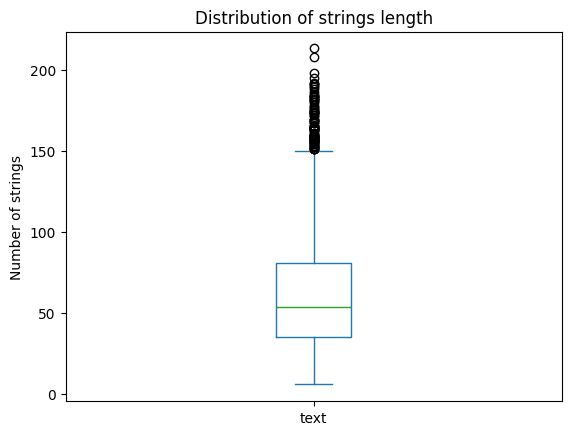

count    4314.000000
mean       61.479369
std        34.839311
min         6.000000
25%        35.000000
50%        54.000000
75%        81.000000
max       213.000000
Name: text, dtype: float64

In [ ]:
strings_len = pd.Series(data["text"]).str.len()

strings_len.plot.box()
plt.title("Distribution of strings length")
plt.ylabel("Number of strings")
plt.show()

strings_len.describe()

You can see most strings are up to 150 words. But with using the describe function on the length of the strings we can see that around 75 % of the comments are up to 80 words long. This will be taken into account when padding. Some sentences may be shorter so they will need to have padding. This is an important stage as we need to decide how many relevant words of the text should be processed within the model. If we use too many the training process will be longer. We can see on the box plot that most of the text lengths are between the 40 to 80 range. So I think it is reasonable to have the input length at 80.    

#### Preparing text to be used with Deep learning model

I will now tokenize the text and pad it. I will also one hot code the labels.

In [ ]:
# encoding emotions
encoded_emotions = {
    "anger" : 0,
    "fear": 1,
    "joy" : 2,
    "love": 3,
    "sadness": 4,
    "surprise": 5
}

data.replace(encoded_emotions, inplace = True)
data.head()

,text,label
17713,feel glad im able time spend time family,2
14436,could look coordinate cave im feeling adventur...,2
8631,need need someone need protected feel safe sma...,2
6740,imagine real life scenario would emotionally c...,2
1381,im feeling optimistic find wanting ride,2


In [ ]:
# Splitting the data into train, val and test before toeknization and padding

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.2, random_state=42,stratify=data["label"])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42,stratify=y_train)

print(f"X_train = {X_train.shape} and y_train = {y_train.shape}")
print(f"X_test = {X_test.shape} and y_test = {y_test.shape}")
print(f"X_val = {X_val.shape} and y_val = {y_val.shape}")


X_train = (2588,) and y_train = (2588,)
X_test = (863,) and y_test = (863,)
X_val = (863,) and y_val = (863,)


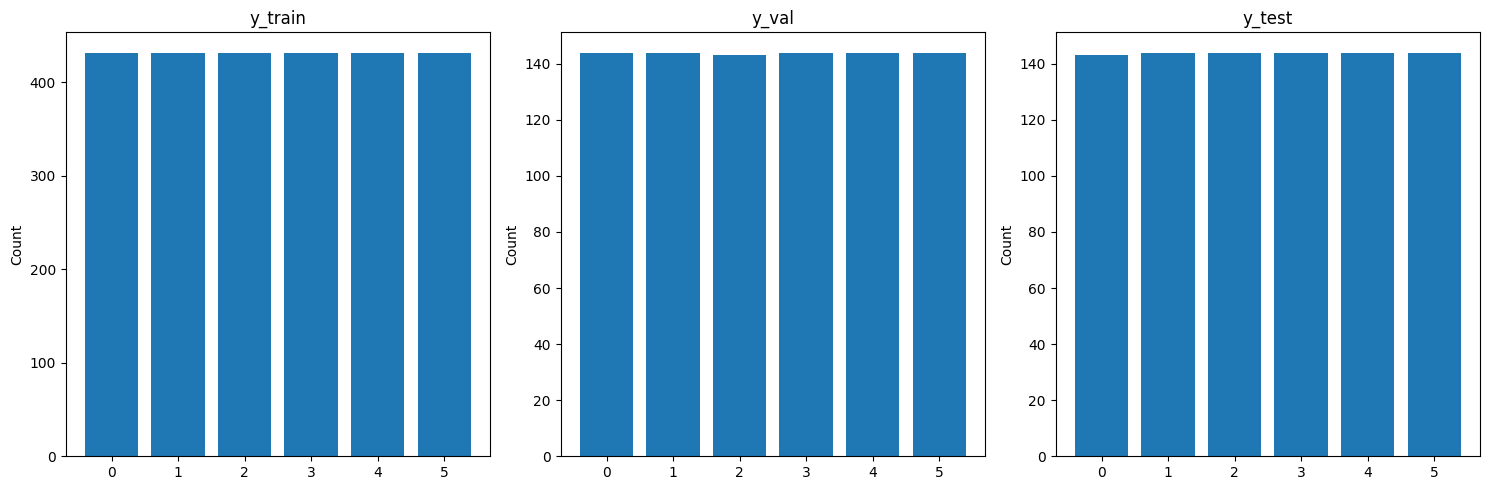

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for y_train
axs[0].bar(y_train.value_counts().index, y_train.value_counts())
axs[0].set_title('y_train')
axs[0].set_ylabel('Count')

# Plot for y_val
axs[1].bar(y_val.value_counts().index, y_val.value_counts())
axs[1].set_title('y_val')
axs[1].set_ylabel('Count')

# Plot for y_test
axs[2].bar(y_test.value_counts().index, y_test.value_counts())
axs[2].set_title('y_test')
axs[2].set_ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Tokenize the text data

max_words = 6000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train.astype(str))

X_train_seq = tokenizer.texts_to_sequences(X_train.astype(str))
X_val_seq = tokenizer.texts_to_sequences(X_val.astype(str))
X_test_seq = tokenizer.texts_to_sequences(X_test.astype(str))


vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(tokenizer.word_index)

for i in range (10):
    print(f"Sequence {i + 1}: {X_train_seq[i]}")


5137
{'feel': 1, 'feeling': 2, 'like': 3, 'im': 4, 'time': 5, 'really': 6, 'little': 7, 'know': 8, 'make': 9, 'people': 10, 'one': 11, 'get': 12, 'day': 13, 'bit': 14, 'thing': 15, 'even': 16, 'still': 17, 'want': 18, 'think': 19, 'would': 20, 'ive': 21, 'life': 22, 'something': 23, 'way': 24, 'love': 25, 'dont': 26, 'could': 27, 'go': 28, 'need': 29, 'back': 30, 'much': 31, 'going': 32, 'always': 33, 'year': 34, 'work': 35, 'overwhelmed': 36, 'though': 37, 'pretty': 38, 'say': 39, 'around': 40, 'weird': 41, 'help': 42, 'didnt': 43, 'strange': 44, 'good': 45, 'also': 46, 'made': 47, 'see': 48, 'right': 49, 'cant': 50, 'many': 51, 'surprised': 52, 'friend': 53, 'lot': 54, 'someone': 55, 'week': 56, 'impressed': 57, 'amazed': 58, 'got': 59, 'kind': 60, 'today': 61, 'sure': 62, 'thought': 63, 'take': 64, 'every': 65, 'never': 66, 'felt': 67, 'keep': 68, 'le': 69, 'amazing': 70, 'curious': 71, 'funny': 72, 'moment': 73, 'book': 74, 'quite': 75, 'look': 76, 'actually': 77, 'anything': 78, '

In [ ]:
max_sequence_length = 80

X_train = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding="post")
X_val = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding="post")
X_test = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding="post")

for i in range (3):
    print(f"Sequence{i +1}: {X_train[i]}")


Sequence1: [   6   63  124    2 2212  291 1496    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Sequence2: [  2 938   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]
Sequence3: [  67  788 2213 2214 2215  142   47    1  470 2216 2217 2218   23  110
 2219   48  125   86    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 

In [ ]:
X_train

array([[   6,   63,  124, ...,    0,    0,    0],
       [   2,  938,    0, ...,    0,    0,    0],
       [  67,  788, 2213, ...,    0,    0,    0],
       ...,
       [  17,   12,  117, ...,    0,    0,    0],
       [1442,   23,  551, ...,    0,    0,    0],
       [ 589,  667,  419, ...,    0,    0,    0]], dtype=int32)

# converting to Tensorflow tensors for the model
X_train_tensor = tf.constant(X__train_padded, dtype=tf.int32)
y_train_tensor = tf.constant(y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))

X_val_tensor = tf.constant(X_val_padded, dtype=tf.int32)
y_val_tensor = tf.constant(y_val, dtype=tf.int32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val_tensor))

print(train_dataset)
print(val_dataset)

### Designing a model

I will now design a model. I will use the Long Short-Term Memory(LSTM) type of RNN model as it handles stochastic gradient failure better than a regular RNN. It can handle longer sequences better. I will start by creating a simple network with one LTSM layer to see how the  model performs.

I will use the following formula to determine the number of nodes within the layer: 

$ N_i = \frac{2}{3} * (N_i + N_o) $

$N_i$ is equal to the number of input words
$N_o$ is equal to number of output neurons

This will give me a basic idea on what number of nodes to begin with then I can adjust after training the model. 

I will also include a Dropout layer to help reduce in overfitting. This will randomly ignore selected neurons during training and reduce the sensitivity of specific weights. I have chosen 0.2 as my starting point as it is a good compromise in retaining accuracy and overfitting.

I will use the softmax activation function in my activation layer as it will interpret the outputs as probabilities for each class.

The model I will build will be simple to begin then it will be built upon by testing different hyperparemters with the keras tuner

In [ ]:
hidden_nodes = int(2/3 * (max_sequence_length * 6))
print(f"The number of hidden nodes is: {hidden_nodes}")

The number of hidden nodes is: 320


In [ ]:
def train_and_evaluate_model(epochs, checkpoint_filepath):
    
    model= Sequential()
    model.add(Embedding(6000, 128, input_length=80))
    # add max pooling
    # add conv 1d
    model.add(Conv1D(filters=3, kernel_size = 100, padding="same",activation="relu"))
    model.add(MaxPooling1D(pool_size=6))
    model.add(GlobalAveragePooling1D())
    model.add(SimpleRNN(526, activation= "tanh", return_sequences=False))
    model.add(Dense(320, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
    
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True
    )

    history = model.fit(X_train, y_train, 
                        validation_data=(X_val,y_val), 
                        epochs=epochs,batch_size=128, 
                        callbacks=[early_stopping, model_checkpoint]) 

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0) # test data results when run through the model
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #visualizing training and validation results
    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())

    best_model = load_model(checkpoint_filepath)
    
    return best_model


In [ ]:
train_and_evaluate_model(50, "../Lab_RNN/model_save")

ValueError: Input 0 of layer "simple_rnn" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 3)

As We can see see this model was not successful at all! I think the model needs to have some more layers. I will now test out keras tuner to test more than one layer and to see which hyper parameters may be more effective. 

In [ ]:
def model_builder(hp):
    model= Sequential()
    model.add(Embedding(20000, 
                        hp.Int("embedding_size", min_value=32, max_value=256, step=32), 
                        input_length=80))
    model.add(LSTM(units= hp.Int("LSTM_units", min_value= 32, max_value=256, step = 32)))
    model.add(Dense(units=hp.Int("Dense_units",min_value = 64, max_value=512, step=64),
                    activation="relu"))
    model.add(Dropout(rate=hp.Choice("dropout", values=[0.2,0.3,0.4,0.5])))
    model.add(Dense(6, activation="softmax"))

    model.compile(
    optimizer=Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

    return model

    

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy', # which parameter to observe
                     max_epochs=10,
                     factor=3, #the reduction factor, The smaller it is the more aggressive reduction in configurations
                     directory='tuner_results_RNN', # results saved to a directory
                     project_name='sentiment')

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3) # early stopping used when better parameters are found to save time in tuning

In [ ]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping]) # The training search

Trial 30 Complete [00h 06m 56s]
val_accuracy: 0.3407500088214874

Best val_accuracy So Far: 0.3407500088214874
Total elapsed time: 02h 11m 07s


In [ ]:
best_model = tuner.get_best_models(num_models=1)
print(best_model[0].summary())

# prints out best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters.values)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 224)           4480000   
                                                                 
 lstm (LSTM)                 (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 320)               82240     
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1926      
                                                                 
Total params: 5056710 (19.29 MB)
Trainable params: 5056710 (19.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
{'embedding

I had a problem with saving the parameters to file. SO i copied the results above just incase I could not retrieve them.

```Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding (Embedding)       (None, 80, 224)           4480000   
                                                                 
 lstm (LSTM)                 (None, 256)               492544    
                                                                 
 dense (Dense)               (None, 320)               82240     
                                                                 
 dropout (Dropout)           (None, 320)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1926      
                                                                 
=================================================================
Total params: 5056710 (19.29 MB)
Trainable params: 5056710 (19.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
{'embedding_size': 224, 'LSTM_units': 256, 'Dense_units': 320, 'dropout': 0.5, 'learning_rate': 0.01, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
Trial 30 Complete [00h 06m 56s]
val_accuracy: 0.3407500088214874

Best val_accuracy So Far: 0.3407500088214874
Total elapsed time: 02h 11m 07s
```


In [ ]:
tuner_hyper = {
    "embed": 224,
    "LSTM1_units" : 256,
    "LSTM2_units" : 256,
    "Dense1_units" : 320,
    "Dense2_units" : 160,
    "dropout" : 0.5,
    "learning_rate" : 0.01


}

In [ ]:
def tuner_model(epochs, checkpoint_filepath,hyperparemeters=None):

    if hyperparemeters is None:
        hyperparemeters = tuner_hyper
    
    model= Sequential()
    model.add(Embedding(input_dim= 20000, output_dim=hyperparemeters["embed"], input_length=80))
    model.add(LSTM(units=hyperparemeters["LSTM1_units"], return_sequences=True))
    model.add(LSTM(units=hyperparemeters["LSTM2_units"],return_sequences=False))
    model.add(Dense(units=hyperparemeters["Dense1_units"], activation="relu"))
    model.add(Dense(units=hyperparemeters["Dense2_units"]))
    model.add(Dropout(rate=hyperparemeters["dropout"]))
    model.add(Dense(6, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=hyperparemeters["learning_rate"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)
    
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath, 
        monitor="val_accuracy", 
        mode="max", verbose=1, 
        save_best_only=True
    )

    # fitting the model to the training model to train
    history = model.fit(X_train,y_train , epochs=epochs, validation_data=(X_val,y_val), callbacks=[early_stopping, model_checkpoint])

    # evaluating the model with the test dataset
    test_loss, test_accuracy =model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # plotting the validation loss and training accuracy
    plt.figure(figsize=(8,8))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss ")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    print(model.summary())
    
    return best_model
    

Epoch 1/50
375/375 [==============================] - ETA: 0s - loss: 1.6170 - accuracy: 0.3239
Epoch 1: val_accuracy improved from -inf to 0.34075, saving model to ../Lab_RNN/model_save
INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


INFO:tensorflow:Assets written to: ../Lab_RNN/model_save/assets


375/375 [==============================] - 246s 647ms/step - loss: 1.6170 - accuracy: 0.3239 - val_loss: 1.5886 - val_accuracy: 0.3408
Epoch 2/50
375/375 [==============================] - ETA: 0s - loss: 1.5854 - accuracy: 0.3280
Epoch 2: val_accuracy did not improve from 0.34075
375/375 [==============================] - 235s 627ms/step - loss: 1.5854 - accuracy: 0.3280 - val_loss: 1.5853 - val_accuracy: 0.3408
Epoch 3/50
375/375 [==============================] - ETA: 0s - loss: 1.5852 - accuracy: 0.3243
Epoch 3: val_accuracy did not improve from 0.34075
375/375 [==============================] - 234s 623ms/step - loss: 1.5852 - accuracy: 0.3243 - val_loss: 1.5841 - val_accuracy: 0.3408
Epoch 4/50
375/375 [==============================] - ETA: 0s - loss: 1.5859 - accuracy: 0.3302
Epoch 4: val_accuracy did not improve from 0.34075
375/375 [==============================] - 234s 625ms/step - loss: 1.5859 - accuracy: 0.3302 - val_loss: 1.5844 - val_accuracy: 0.3408
Epoch 5/50
375/375 

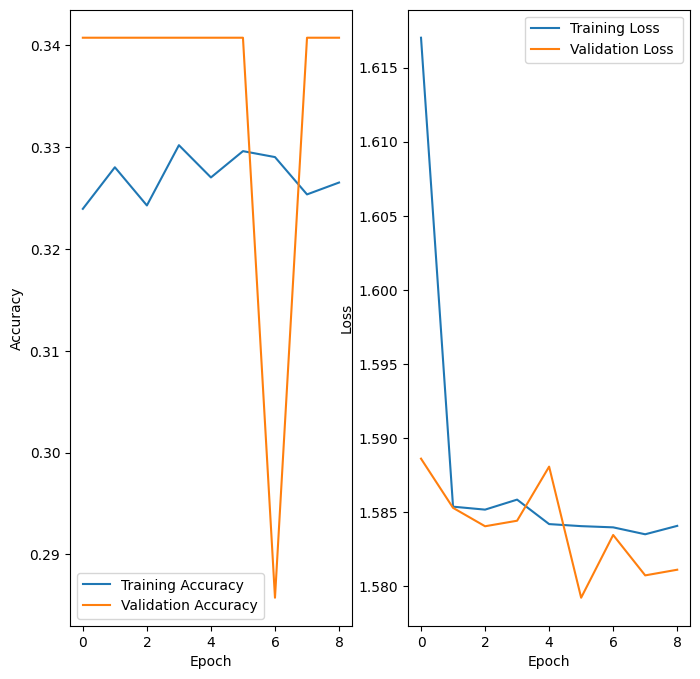

In [ ]:
tuner_model(50, "../Lab_RNN/model_save",None)